# ENSO example notebook

This notebook contains an example of data access of ERA5 data with the `Reader` class and evaluation of the NINO3.4 teleconnection (regional mean) with `aqua` libraries and examples of the plotting routines.

In [2]:
import sys
from aqua import Reader
sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from index import regional_mean_index, regional_mean_anomalies
from plots import simple_plot, cor_plot, index_plot
from tools import load_namelist

## Teleconnection details configuration

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file. The function `load_namelist` loads data specific to the choosen teleconnection such as coordinates.

Details about the ENSO teleconnection can be accessed by specificing the teleconnection name as a string. The field required to evaluate the teleconnection is also specified in the `namelist`. (WIP to be automatically fixed by the reader)

## ENSO with IFS data

In [4]:
diagname  = 'teleconnections'
telecname = 'ENSO'

model = 'IFS'
exp = 'tco1279-orca025-cycle3'
source = '2D_monthly_native'

namelist = load_namelist(diagname)

field = namelist[telecname]['field']
print(field)

skt


## Retrieve data with the intake AQUA functionality

Data required for the teleconnection are retrieved with the `Reader` class from the `AQUA` framework (see framework notebooks for a comprehensive list of examples).

In [5]:
reader = Reader(model=model,exp=exp,source=source,regrid='r100')

2023-06-01 12:37:10 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco1279-orca025-cycle3, source 2D_monthly_native


In [6]:
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:  (time: 60, value: 6599680)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2024-12-15
Dimensions without coordinates: value
Data variables: (12/59)
    100u     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

## Data preparation

The `Reader` returns a `Dataset`. It is needed to select the data for the desired variable and regrid before calling the library function.

In [7]:
infile = data[field]
infile = reader.regrid(infile)
infile

<xarray.DataArray 'skt' (time: 60, lat: 180, lon: 360)>
dask.array<reshape, shape=(60, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2024-12-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/17)
    paramId:                    235
    dataType:                   fc
    numberOfPoints:             6599680
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   avg
    ...                         ...
    missingValue:               3.4028234663852886e+38
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1
    history:                    2023-06-01 12:37:44 regridded by AQUA regridd...

## Teleconnection evaluation

The NINO3.4 can be evaluated by using the library function `regional_mean_index` from the `index.py` file.

The teleconnection can be evaluated with a custom rolling window to average data (standard is 3 months, here written explicitely for sake of clarity).

The function returns a `DataArray` with the timeserie of values.


In [8]:
enso = regional_mean_index(infile,namelist,telecname,months_window=1)

The timeserie can be plot with the `simple_plot` function from the `plots.py` file, already with some extra optional arguments in order to make a nice plot.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'ENSO Index, Nino 3.4'}, xlabel='time', ylabel='Skin temperature [K]'>)

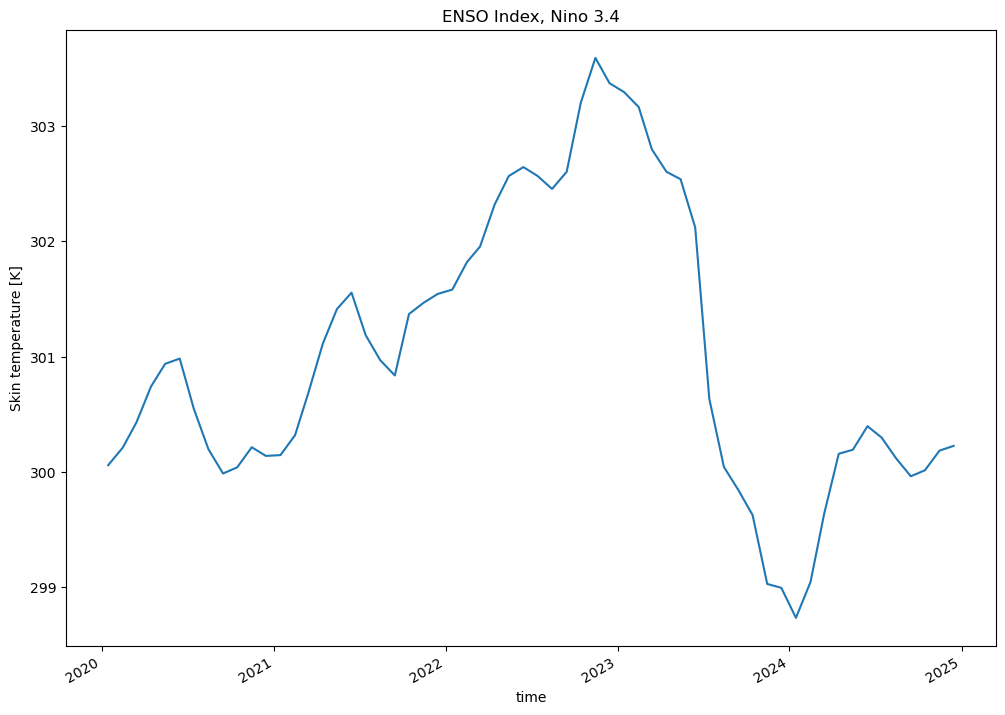

In [9]:
simple_plot(enso,title='ENSO Index, Nino 3.4',ylabel='Skin temperature [K]',
            save=False)

## Correlation plot

To visualize the teleconnection on a 2D plot functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the correlation. Additionally an xarray containing the result of the regression is returned, if needed for further analysis or storage.
A custom projection can be specified.

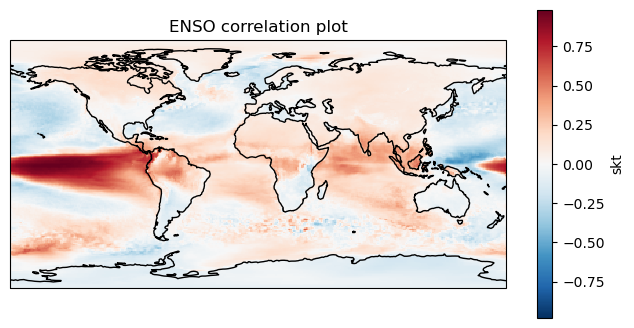

In [10]:
enso_cor = cor_plot(enso,infile,title='ENSO correlation plot',save=False)

## ENSO Nino3.4 anomalies

Another library function is introduced, able to evaluate anomalies of a regional mean index. The function `regional_mean_anomalies` returns a `DataArray` with the anomalies.

Also for this function, an optional parameter `months_window` can be specified to average the data before computing the anomalies.

In [11]:
enso_an = regional_mean_anomalies(infile,namelist,telecname,months_window=1)

The timeserie can be plot with the `index_plot` function from the `plots.py` file, already with some customization in order to make a nice plot.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'ENSO Anomalies, Nino 3.4'}, xlabel='time', ylabel='Skin temperature anomalies [K]'>)

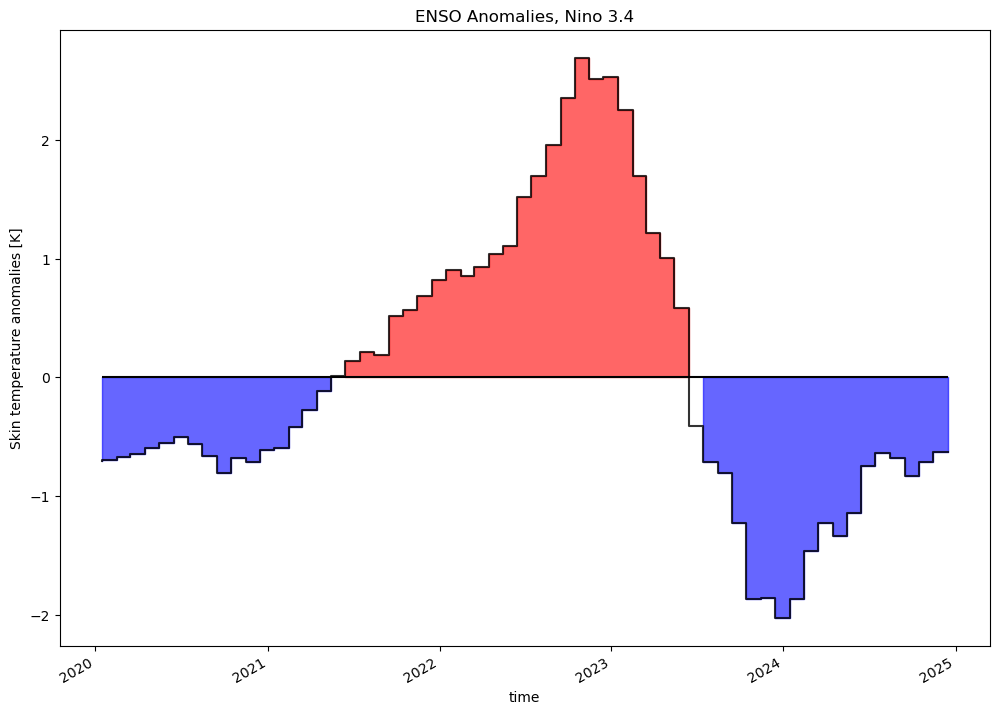

In [12]:
index_plot(enso_an,title='ENSO Anomalies, Nino 3.4',ylabel='Skin temperature anomalies [K]',
           save=False)

## ENSO with ICON data

In [44]:
model = 'ICON'
exp = 'ngc3028'
source = 'P1D'

In [45]:
reader = Reader(model=model, exp=exp, source=source, zoom=8, regrid='r025', freq='monthly')

In [46]:
data = reader.retrieve()
infile = data[field]
infile = reader.timmean(infile)
infile = reader.regrid(infile)
infile

<xarray.DataArray 'skt' (time: 67, lat: 720, lon: 1440)>
dask.array<reshape, shape=(67, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-02-01 ... 2025-07-01
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    cell_methods:   time: mean cell: mean
    component:      atmo
    grid_mapping:   crs
    long_name:      Skin temperature
    standard_name:  surface_temperature
    units:          K
    vgrid:          surface
    history:        2023-06-01 12:54:41 variable renamed by AQUA fixer;\n2023...
    paramId:        235
    cfVarName:      skt
    shortName:      skt
    regridded:      1

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'ENSO Index, Nino 3.4'}, xlabel='time', ylabel='Skin temperature [K]'>)

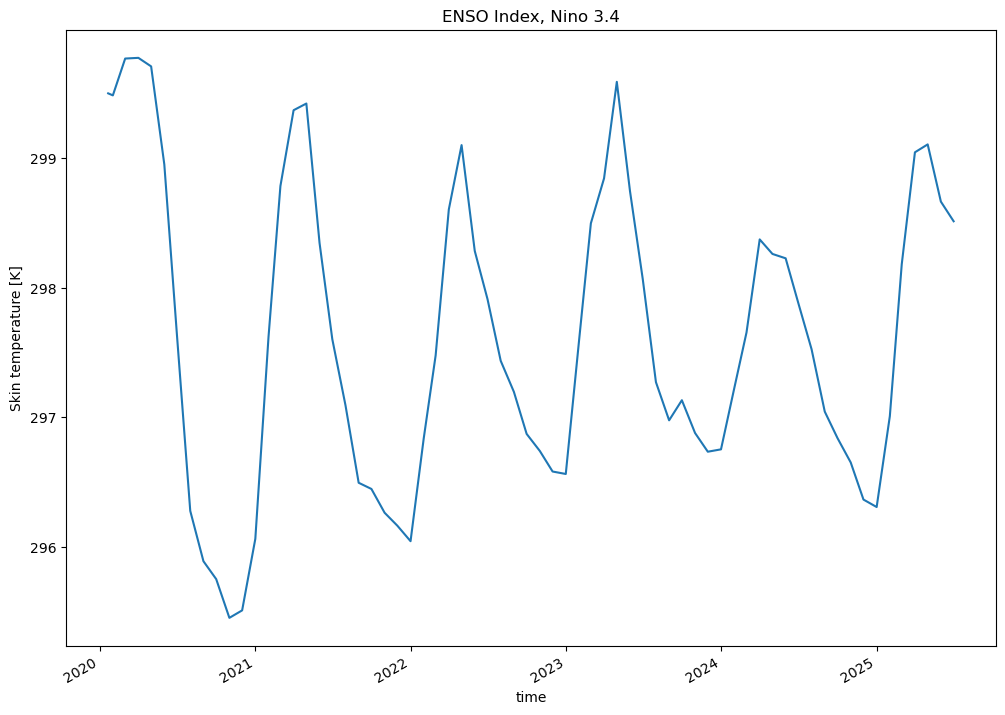

In [47]:
enso_ICON = regional_mean_index(infile,namelist,telecname,months_window=1)
simple_plot(enso_ICON,title='ENSO Index, Nino 3.4',ylabel='Skin temperature [K]',
            save=False)

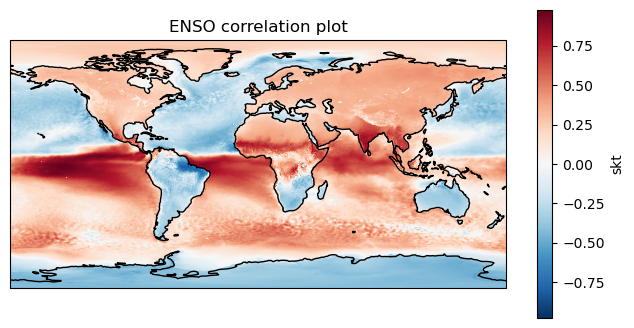

In [48]:
enso_cor = cor_plot(enso_ICON,infile,title='ENSO correlation plot',save=False)

## NCAR comparison

With the NINO3.4 anomalies and monthly data computed, we can compare with observational data from NCAR, to check if the index is computed correctly.

In [13]:
import numpy as np
ncar_path = '../data/nina34.anom.txt'
enso_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

In [14]:
# If some missing value is remaining
for i in enso_ncar:
    for j in i:
        if j == -99.99:
            j = np.nan

In [15]:
import xarray as xr
year = enso_ncar[:,0]
month_data = enso_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
enso_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

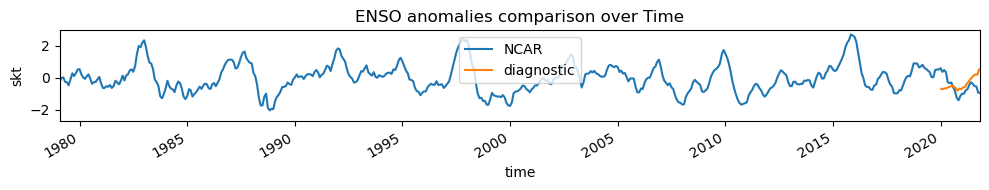

In [17]:
import datetime
import matplotlib.pyplot as plt
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,2))
plt.plot(datetimes, enso_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1979, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))
#plt.ylim(-5,+5)

enso_an.plot(label='diagnostic')
plt.legend()
plt.title('ENSO anomalies comparison over Time')
fig.tight_layout()
#plt.savefig('../img/enso_an_ncar.png')
plt.show()

In [18]:
ncar_path = '../data/nina34.txt'
enso_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

In [19]:
year = enso_ncar[:,0]
month_data = enso_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
enso_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

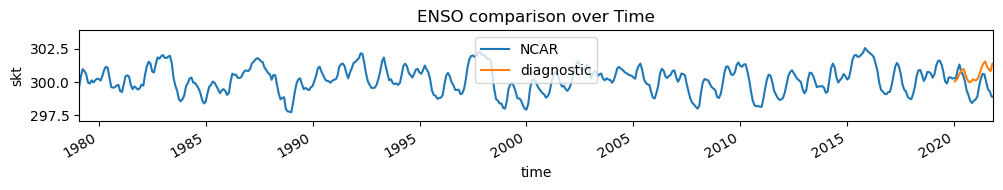

In [20]:
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,2))
plt.plot(datetimes, enso_ncar.values+273.15,label='NCAR')

plt.xlim(datetime.datetime(1979, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))

enso.plot(label='diagnostic')
plt.legend()
plt.title('ENSO comparison over Time')
fig.tight_layout()
#plt.savefig('../img/enso_ncar.png')
plt.show()